In [1]:
## This script evaluates the correlations between models and experimental datasets
# Requires that sentence pairwise similarities have already been computed using 'Cals_sent_sim_[type].ipynb' files
# Run using base python 3.9
# James Fodor 2023

# load libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sentence_embeds_processing as sep
import scipy
import json
import os
import re

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

# load file paths
with open("file_paths.json", "r") as file:
    file_paths_dict = json.load(file)

# set display options
np.set_printoptions(precision=4, threshold=5000, linewidth=220, suppress=True, floatmode='fixed')
sns.set()

### Load sentence pairs and similarity data

In [2]:
## Show available sentence datasets, as specified in the sentence_embeds_processing module
pairs = True # specify if we are using paired data or list of sentences
if pairs==True:
    datasets = sep.available_pair_datasets
else:
    datasets = sep.available_nonpaired_datasets
for dataset in datasets.keys():
    print(dataset,datasets[dataset])

0 GS2011_processed
1 KS2013_processed
2 Fodor_pilot_2022
3 STS131_processed
4 SICK_relatedness
5 STSb_captions_test
6 STSb_forums_test
7 STSb_headlines_test
8 STSb_test
9 STS3k_all


In [3]:
## Load sentence datasets from file from the list above

# Load sentence set
dataset_name = datasets[9] # get the desired dataset
sentences_dict = sep.load_set_of_sentences(dataset_name, file_paths_dict['data_pairs_path'], file_paths_dict['data_nonpaired_path'], pairs)
print('loaded',dataset_name)

# get experimental similarities for sentence pairs    
if pairs==True:
    sim_storage = {}
    sim_storage['expr'] = np.array(list(sentences_dict.values()))[:,2].astype(float)

# load verbnet parse data
json_path = file_paths_dict['parses_path']+'VerbNet Parsing\\full_VerbNet_pass_'+dataset_name+'_mod.json'
sentence_pair_parsed_dict = json.load(open(json_path)) # load verbnet parse data from json
n = len(list(sentence_pair_parsed_dict.keys()))

loaded STS3k_all


In [10]:
## Load similarity data for all models for the specified sentence dataset

# loop over all model functions to load data
all_files = os.listdir(file_paths_dict['sims_path'])
for file_name in all_files:
    
    # Regular expression pattern to match files for given model
    filename_pattern = r"^{}.*\.txt$".format(dataset_name)

    # Check if the filename matches the pattern
    if re.match(filename_pattern, file_name):
        basename_pattern = r"{}_(.*?)_similarities.txt".format(dataset_name) # extract basename to save
        base_name = sep.extract_text_between(basename_pattern, file_name)[0]
        sim_storage[base_name] = sep.load_sentence_sim_values(file_paths_dict['sims_path']+file_name)
        
print(len(sim_storage),'files loaded')

51 files loaded


### Load full dataset (STS3k only)

This section loads additional information about the subtypes of stimuli, relevant for STS3k dataset.

In [5]:
## Load full dataset
all_expr_data = np.loadtxt(file_paths_dict['path_root']+'\\Sentence Similarity Data\\Fodor2023 - STS3k Large Dataset\\3 - Experimental data\\STS3k_all_full_expr_501.txt',  delimiter=';', dtype='str')
print(all_expr_data[0]) # show categories of data for use
col_dict = dict(zip(all_expr_data[0], np.arange(len(all_expr_data[0]))))

['Main ID' 'Adversarial' 'Type ID' 'Sentence 1' 'Sentence 2' 'Set' 'Sim' 'Sent Type' 'Mod 1' 'Mod 2' 'Mod 3' 'Mod 4' 'Mod 5' 'Mod 6']


In [6]:
## Define sets of sentence types and modifiers for STS3k
sent_types = ['CONST_VERB','CONST_SUBJ','CONST_DOBJ','AB_VERB','AB_SUBJ','AB_DOBJ','ADJECTIVE','OTHER','ZERO','SWAP_DOBJ_VERB','SWAP_SUBJ_DOBJ','SWAP_SUBJ_VERB','TRIPLE','QUAD','PARAPHRASE','NEGATIVE','ONLY_MOD']
sent_types_indices = [list(np.where(all_expr_data[1:,col_dict['Sent Type']] == sent_type)[0]) for sent_type in sent_types]
sent_types_dict = dict(zip(sent_types, sent_types_indices))
sent_types_dict['ONLY_MOD'] = sent_types_dict['ONLY_MOD']+[5,6,7,8,9] # add on 'CHECK' data with identical sentences

# Modifier levels (no mods, 1 mod, 2 mods, ...)
modifier_lvl_dict = {0: list(np.where(all_expr_data[1:,col_dict['Mod 1']] == '')[0]),
                     1: np.intersect1d(list(np.where(all_expr_data[1:,col_dict['Mod 1']] != '')[0]), list(np.where(all_expr_data[1:,col_dict['Mod 2']] == '')[0])),
                     2: np.intersect1d(list(np.where(all_expr_data[1:,col_dict['Mod 2']] != '')[0]), list(np.where(all_expr_data[1:,col_dict['Mod 3']] == '')[0])),
                     3: np.intersect1d(list(np.where(all_expr_data[1:,col_dict['Mod 3']] != '')[0]), list(np.where(all_expr_data[1:,col_dict['Mod 4']] == '')[0])),
                     4: np.intersect1d(list(np.where(all_expr_data[1:,col_dict['Mod 4']] != '')[0]), list(np.where(all_expr_data[1:,col_dict['Mod 5']] == '')[0])),
                     5: list(np.where(all_expr_data[1:,col_dict['Mod 5']] != '')[0])}
average_score_by_type = np.zeros((len(sent_types),6))

# Sentence types (para, swaps, triples, quads)
para_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'PARAPHRASE')[0])
ab_verb_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'AB_VERB')[0])
ab_subj_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'AB_SUBJ')[0])
ab_dobj_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'AB_DOBJ')[0])
single_indices = ab_verb_indices+ab_subj_indices+ab_dobj_indices
const_verb_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'CONST_VERB')[0]) 
const_subj_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'CONST_SUBJ')[0]) 
const_dobj_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'CONST_DOBJ')[0]) 
swap_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'SWAP_DOBJ_VERB')[0]) + list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'SWAP_SUBJ_DOBJ')[0]) + \
    list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'SWAP_SUBJ_VERB')[0])
triple_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'TRIPLE')[0])
quad_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'QUAD')[0])
neg_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'NEGATIVE')[0])
zero_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'ZERO')[0])
other_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'OTHER')[0])
onlymod_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'ONLY_MOD')[0])
onlymod_1_indices = [x for x in modifier_lvl_dict[1] if x in onlymod_indices]
onlymod_2_indices = [x for x in modifier_lvl_dict[2] if x in onlymod_indices]
onlymod_3_indices = [x for x in modifier_lvl_dict[3] if x in onlymod_indices]
onlymod_4_indices = [x for x in modifier_lvl_dict[4] if x in onlymod_indices]
onlymod_6_indices = [x for x in modifier_lvl_dict[5] if x in onlymod_indices]
adjective_indices = list(np.where(all_expr_data[1:,col_dict['Sent Type']] == 'ADJECTIVE')[0])
simple_quads = np.intersect1d(list(np.where(all_expr_data[1:,col_dict['Mod 1']] == '')[0]), quad_indices)
simple_triples = np.intersect1d(list(np.where(all_expr_data[1:,col_dict['Mod 1']] == '')[0]), triple_indices)
simple_swaps = np.intersect1d(list(np.where(all_expr_data[1:,col_dict['Mod 1']] == '')[0]), swap_indices)

# Types of modifiers (time, manner, place)
place_indices = list(np.where(all_expr_data[1:,col_dict['Mod 1']] == 'PLACE')[0])
time_indices = list(np.where(all_expr_data[1:,col_dict['Mod 1']] == 'TIME')[0])
manner_indices = list(np.where(all_expr_data[1:,col_dict['Mod 1']] == 'MANNER')[0])
addiobj_indices = list(np.where(all_expr_data[1:,col_dict['Mod 1']] == 'add IOBJ')[0])
subja_indices = list(np.where(all_expr_data[1:,col_dict['Mod 1']] == 'SUBJ adj')[0])
dobja_indices = list(np.where(all_expr_data[1:,col_dict['Mod 1']] == 'DOBJ adj')[0])
iobja_indices = list(np.where(all_expr_data[1:,col_dict['Mod 1']] == 'IOBJ adj')[0])
passive_indices = list(np.where(all_expr_data[1:,col_dict['Mod 1']] == 'PASSIVE')[0])
only_mods_lvl_1 = np.intersect1d(modifier_lvl_dict[1], sent_types_dict['ONLY_MOD']) # mod_only sentence pairs

# Word sets (test, train, dev, adversarial)
set_test = list(np.where(all_expr_data[1:,col_dict['Set']] == 'TEST')[0])
set_dev = list(np.where(all_expr_data[1:,col_dict['Set']] == 'DEV')[0])
set_train = list(np.where(all_expr_data[1:,col_dict['Set']] == 'TRAIN')[0])
all_adversarial = list(np.where(all_expr_data[1:,col_dict['Adversarial']] == 'ADV')[0])
non_adversarial = list(np.where(all_expr_data[1:,col_dict['Adversarial']] == 'NADV')[0])
all_adversarial_no_neg = swap_indices+triple_indices+quad_indices+para_indices
revised_adversarial = swap_indices+triple_indices+quad_indices+onlymod_indices+para_indices+neg_indices
revised_adversarial_no_neg = swap_indices+triple_indices+quad_indices+onlymod_indices+para_indices
revised_adversarial_no_neg_no_para = swap_indices+triple_indices+quad_indices+onlymod_indices
all_indices = list(np.arange(0,len(sentence_pair_parsed_dict.keys())))
revised_nonadversarial_no_neg = [x for x in all_indices if x not in revised_adversarial]

### Compute correlations with experimental similarities

This section computes the actual correlations between experimental dataset and models

In [9]:
## Print all models in table format, showing pearson and spearman correlations with experimental similarities

# Specify indices of interest
desired_indices = all_indices
# desired_indices = revised_adversarial_no_neg
# desired_indices = revised_nonadversarial_no_neg

# Define names
models_list = list(sim_storage.keys())
spearman_correls = np.zeros(len(models_list))
pearson_correls = np.zeros(len(models_list))

# Loop over all models and compile results
for i,model_name in enumerate(models_list):
           
    # compute correlation given model name
    try:
        spearman_correls[i] = spearmanr(sim_storage['expr'][desired_indices], sim_storage[model_name][desired_indices])[0]
        pearson_correls[i] = np.corrcoef(sim_storage['expr'][desired_indices], sim_storage[model_name][desired_indices])[0,1]
    except:
        spearman_correls[i] = 0
        pearson_correls[i] = 0
        # print(model_name)

# Print table of results
print('                                                                              '+dataset_name)
print('                                                                             pears  spear')
for row_num,row in enumerate(spearman_correls):
    print(models_list[row_num].rjust(75,' '),'{: .3f} {: .3f}'.format(pearson_correls[row_num],spearman_correls[row_num]))

                                                                              STS3k_all
                                                                             pears  spear
                                                                       expr  1.000  1.000
                                                              amrbart_norml  0.570  0.490
                                                                    amrbart  0.517  0.422
                                                                        AMR  0.603  0.602
                                                                       conv -0.055 -0.042
                                                          defsent_cls_norml  0.715  0.701
                                                                defsent_cls  0.634  0.618
                                                         defsent_mean_norml  0.701  0.674
                                                               defsent_mean  0.642  0.621
            

### Plot scatterplots

verbnet_conceptnet_none_none_nfold_10x


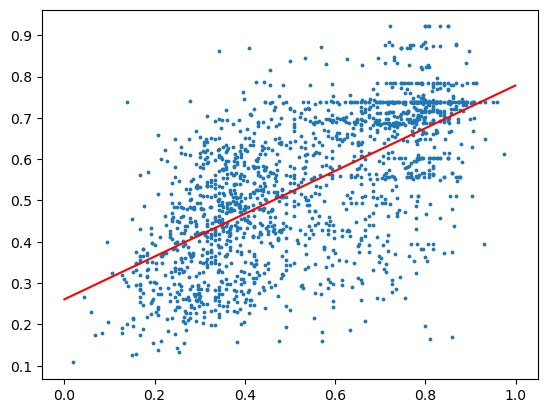

verbnet_conceptnet_mean_reg_nfold_10x


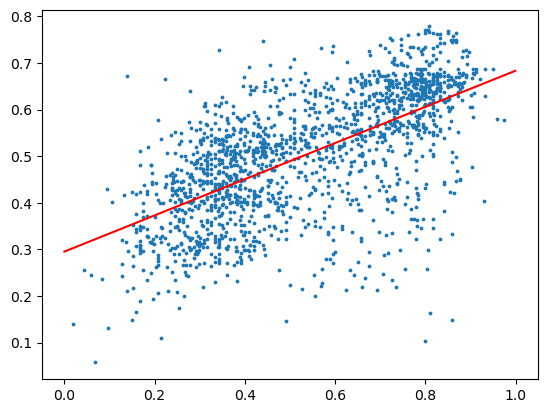

defsent_cls_norml


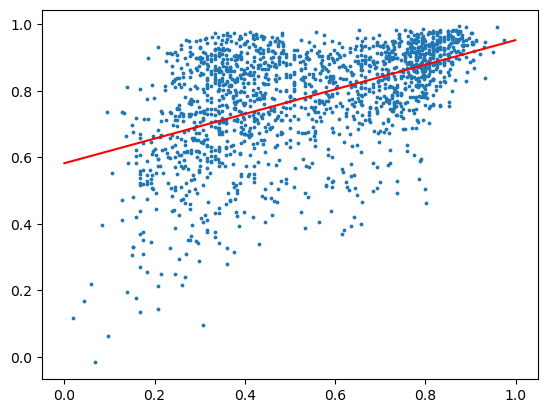

AMR


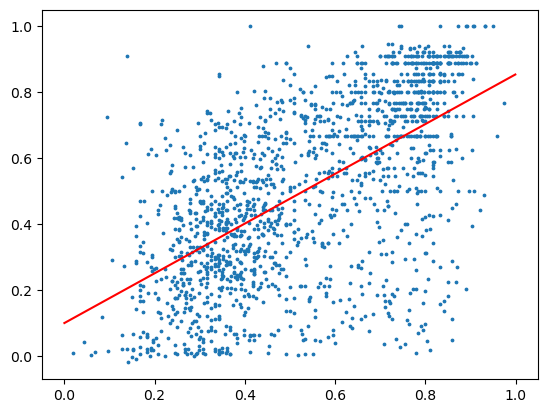

openai_norml


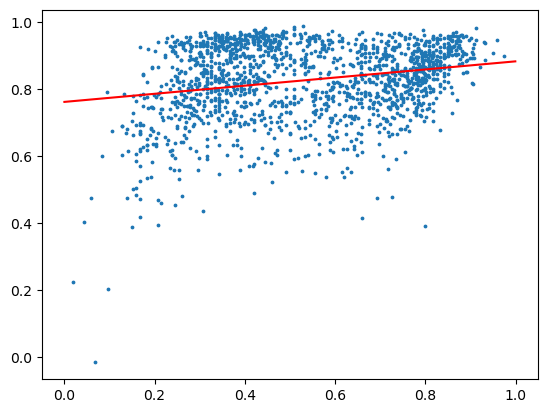

sentbert_mpnet_norml


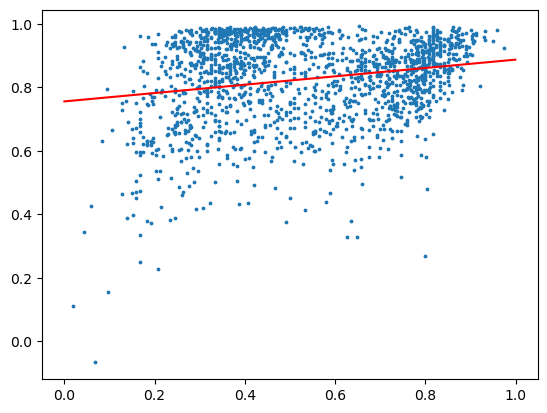

In [23]:
## Generate scatterplots of model vs experimental data

# Select indices to include
desired_indices = revised_adversarial_no_neg
# desired_indices = all_indices

# Select models for plotting
models_to_plot = ['verbnet_conceptnet_none_none_nfold_10x','verbnet_conceptnet_mean_reg_nfold_10x', 'defsent_cls_norml', 'AMR', 'openai_norml', 'sentbert_mpnet_norml']
for model in models_to_plot:

    # Construct regression line
    xs = sim_storage['expr'][desired_indices].reshape(-1, 1)
    ys = sim_storage[model][desired_indices].reshape(-1, 1)
    line_best_fit = LinearRegression().fit(xs, ys)
    plot_xs = np.arange(0,1,0.001)

    # Plot a single scatterplot
    print(model)
    plt.scatter(xs, ys, s=3) # s gives dot size
    plt.plot(plot_xs, line_best_fit.intercept_[0]+line_best_fit.coef_[0]*plot_xs, color='red', linewidth=1.5) # add reg line
    plt.show()

### Sentence type and modifier analysis (STS3k only)

These plots are for detailed interperetation of different sentence subtypes, relevant for STS3k dataset. The interpretation of these plots is discussed in more detail in the paper.

In [11]:
## Default parameters for all plots in this section
models_to_examine = ['expr', 'mean', 'sentbert_mpnet_norml', 'openai_norml', 'defsent_cls_norml', 'verbnet_conceptnet_none_none_nfold_10x'] 
model_names = ['Human', 'Mean', 'SentBERT', 'OpenAI', 'DefSent', 'VerbNet-CN']
sent_types_subset_dict = {'Mod': onlymod_1_indices+onlymod_2_indices, 'Para': para_indices, 'Single':single_indices, 'Swap':swap_indices, 'Triple':triple_indices, 'Quad':quad_indices, 'Neg':neg_indices, 'Zero':zero_indices}
font_size = 12
bar_width = 0.15
plot_offsets = [-5,-3,-1,+1,+3,+5]
# plot_offsets = [-4,-2,0,+2,+4]

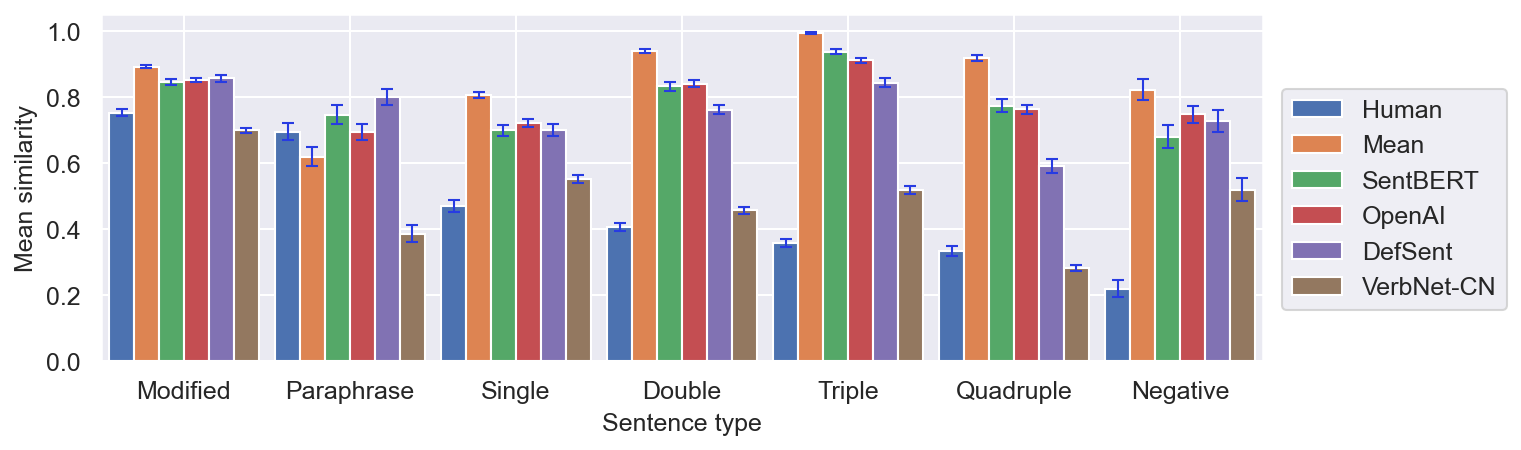

In [12]:
## Plot mean similarities by sentence type

# Prepare plot
fig, ax = plt.subplots(figsize=(10,3), dpi=150)
n_types = len(list(sent_types_subset_dict.keys()))
font_size = 12
x_axis = np.arange(n_types)
x_axis_labels = ['Modified', 'Paraphrase', 'Single', 'Double', 'Triple', 'Quadruple', 'Negative', 'Zero']

# Select datasets and add bars for each
mean_sim_storage = []
i=0
for model in models_to_examine:
    sim_data = sim_storage[model]
    offset = plot_offsets[i]

    # Initialise storage of results
    average_score_by_type_subset = []
    error_bar_by_type_subset = []
    counts_by_type_subset = []

    # Loop over all sentence types (rows) and all modifier counts (cols)
    for row,sent_type in enumerate(sent_types_subset_dict.keys()):
        indices_of_interest = sent_types_subset_dict[sent_type]
        average_score_by_type_subset.append(sim_data[indices_of_interest].mean())
        n = sim_data[indices_of_interest].shape[0]
        error_bar_by_type_subset.append(scipy.stats.t.ppf(q=0.975, df=n)*sim_data[indices_of_interest].std()/np.sqrt(n))
        counts_by_type_subset.append(len(sim_data[indices_of_interest]))
        
    # Add bars and error bars for detailed breakdown
    ax.bar(x=x_axis+offset*bar_width/2, height=average_score_by_type_subset, width=bar_width, label=model_names[i])
    ax.errorbar(x=x_axis+offset*bar_width/2, y=average_score_by_type_subset, yerr=error_bar_by_type_subset, fmt=',', capsize=3, elinewidth=1, color="#273be2")
    i=i+1
    # print(average_score_by_type_subset)
    mean_sim_storage.append(average_score_by_type_subset)

# Add labels and axes
ax.set_ylabel('Mean similarity', fontsize=font_size)
ax.set_xlabel('Sentence type', fontsize=font_size)
ax.set_xticks(list(x_axis))
ax.set_xticklabels(x_axis_labels)
ax.set_xlim(-0.5,6.5)
ax.set_ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.legend(fontsize=font_size, bbox_to_anchor=(1.22, 0.82), loc='upper right')
plt.show()

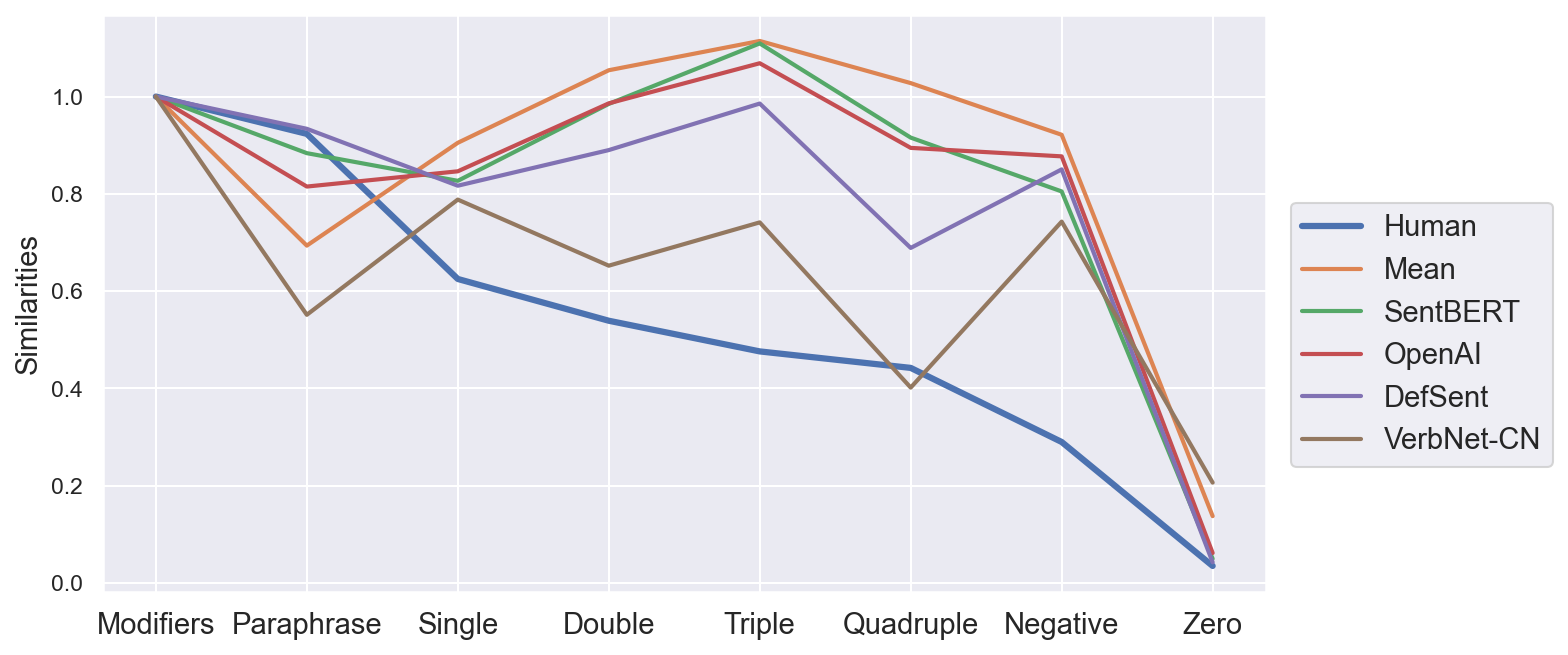

In [13]:
## Plot rates similarities by number of modifications

# Prepare plot
plt.figure(figsize=(10,5), dpi=150)
data_array = np.array(mean_sim_storage)
linewidths = [3,2,2,2,2,2]
font_size = 14
bar_width = 0.15
x_axis = np.arange(n_types)
x_axis_labels = ['Modifiers', 'Paraphrase', 'Single', 'Double', 'Triple', 'Quadruple', 'Negative', 'Zero']

# Normalise array by first value of each row
for i,row in enumerate(data_array):
    offset = plot_offsets[i]
    norm_row = row/row[0]
    plt.plot(np.array(norm_row), label=model_names[i], linewidth=linewidths[i]) # line plot version
    # plt.bar(x=x_axis+offset*bar_width/2, height=np.array(norm_row), width=bar_width, label=model_names[i]) # bar plot version

# Add labels and axes
plt.legend(fontsize=font_size, bbox_to_anchor=(1.26, 0.7), loc='upper right')
plt.xticks(x_axis, x_axis_labels, fontsize=font_size)
plt.ylabel('Similarities', fontsize=font_size)
plt.show()

Analysis of fine-tuned models using the STS3k dataset. For SentBERT, finetuning is done using the 'SentenceBERT_finetuning.ipynb' file. For the VerbNet-CN model, fine-tuning consists of training a feedforward neural network on top of the elementwise semantic similarities, which is performed in step 5 of the 'Calc_sent_sim_VerbNet_behav.ipynb' notebook. The fine-tuned embeddings are saved and loaded for analysis in this notebook.

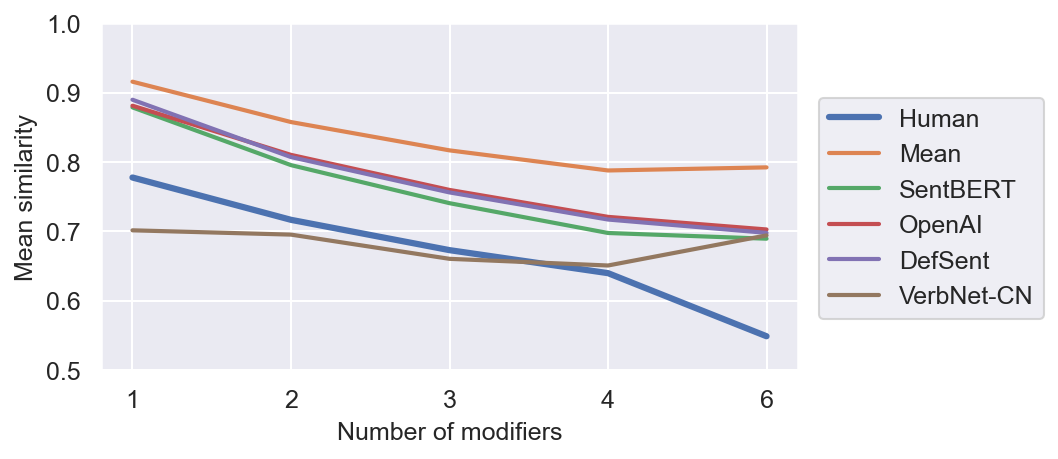

Differences across number of modifiers
[-0.0062 -0.0349 -0.0096  0.0217]


In [97]:
## Compute average similarity by sentence type and modifier count and plot graph

# Prepare bar plot
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
x_axis = np.arange(6)
# x_axis_labels = [0,1,2,3,4,6]
linewidths = [3,2,2,2,2,2]
font_size = 12

# Select datasets to plot and add bars
i=0
for model in models_to_examine:
    sim_data = sim_storage[model]
    offset = plot_offsets[i]

    # Initialise storage of results
    average_score_by_type_subset = np.zeros((len(sent_types),6))
    error_bar_by_type_subset = np.zeros((len(sent_types),6))

    # Loop over all sentence types (rows) and all modifier counts (cols)
    for row,sent_type in enumerate(sent_types):
        for col,level in enumerate(list(modifier_lvl_dict.keys())):
            indices_of_interest = np.intersect1d(sent_types_dict[sent_type], modifier_lvl_dict[level])
            if sim_data[indices_of_interest].shape[0]==0: # cells with no data
                average_score_by_type_subset[row,col] = np.nan
                error_bar_by_type_subset[row,col] = np.nan
            else: # store results in table
                average_score_by_type_subset[row,col] = sim_data[indices_of_interest].mean()
                n = sim_data[indices_of_interest].shape[0]
                error_bar_by_type_subset[row,col] = scipy.stats.t.ppf(q=0.975, df=n)*sim_data[indices_of_interest].std()/np.sqrt(n)

    # Print results as table
    # print(model)
    # print('                 0 mod  1 mod  2 mod  3 mod  4 mod  6 mod')
    # for idx,row in enumerate(average_score_by_type_subset):
    #     print(sent_types[idx].rjust(15,' '),row) # right justify labels
        
    # Add bars and error bars
    mean_similarities = average_score_by_type_subset[-1] # get final row of table with 'only mods'
    std_errs_mean = error_bar_by_type_subset[-1]
    norm_mean_similarities = mean_similarities/mean_similarities[0]
    ax.plot(mean_similarities[1:], label=model_names[i], linewidth=linewidths[i])
    # ax.bar(x=x_axis+offset*bar_width/2, height=mean_similarities, width=bar_width, tick_label=[0,1,2,3,4,6], label=model_names[i])
    # ax.errorbar(x=x_axis+offset*bar_width/2, y=mean_similarities, yerr=std_errs_mean, fmt=',', capsize=3, elinewidth=1, color="#273be2")
    i=i+1

# Add labels and axes
ax.set_ylabel('Mean similarity', fontsize=font_size)
ax.set_xlabel('Number of modifiers', fontsize=font_size)
ax.set_xticks([0,1,2,3,4],[1,2,3,4,6])
ax.set_ylim(0.5,1)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.legend(fontsize=font_size, bbox_to_anchor=(1.37, 0.82), loc='upper right')
plt.show()

# Print element-wise differences
diffs = []
for i in np.arange(1,5):
    if i==4:
        diffs.append(np.ediff1d(mean_similarities)[i]/2)
    else:
        diffs.append(np.ediff1d(mean_similarities)[i])
print('Differences across number of modifiers')
print(np.array(diffs))

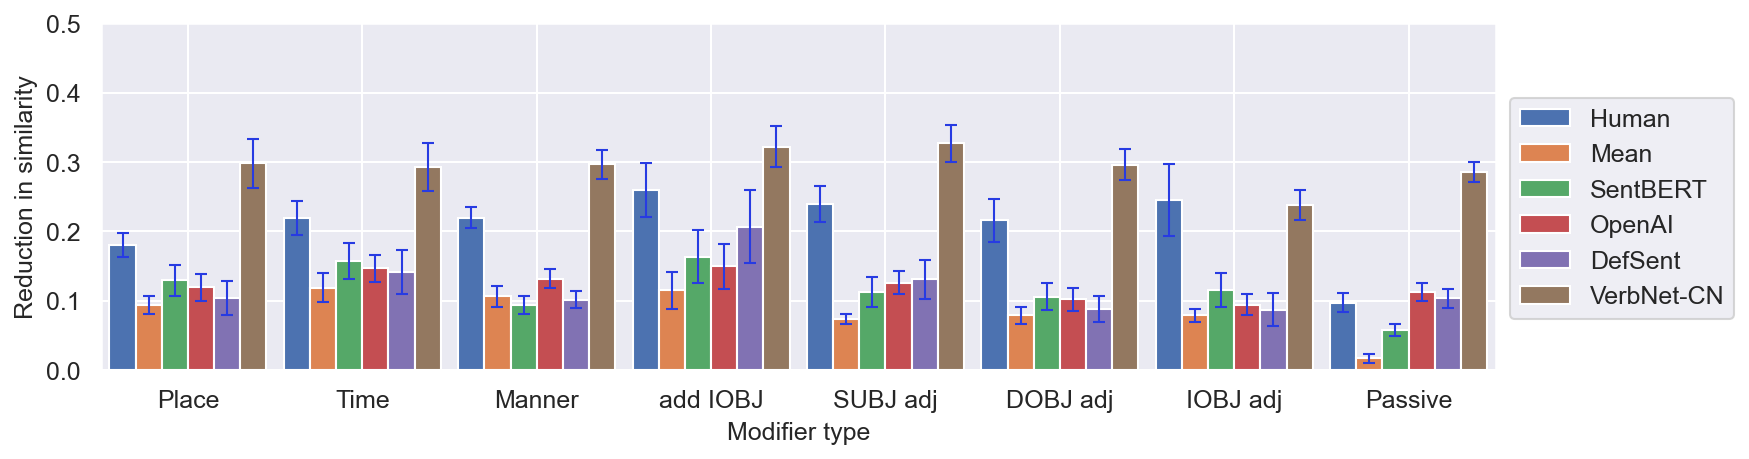

In [66]:
## Analysis of mod types for single modifications

# Prepare bar plot
fig, ax = plt.subplots(figsize=(12,3), dpi=150)
x_axis = np.arange(8)
x_axis_labels = ['Place', 'Time', 'Manner', 'add IOBJ', 'SUBJ adj', 'DOBJ adj', 'IOBJ adj', 'Passive']
font_size = 12

# Select dataset to examine
i=0
for model in models_to_examine:
    sim_data = sim_storage[model]
    offset = plot_offsets[i]

    # Extract mean similarities for each modifier
    mod_indices = [place_indices, time_indices, manner_indices, addiobj_indices, subja_indices, dobja_indices, iobja_indices, passive_indices]
    mean_similarities = []
    sem_similarities = []
    for mod_index_set in mod_indices:
        mod_specific_data = sim_data[np.intersect1d(only_mods_lvl_1, mod_index_set)]
        mean_similarities.append(1-mod_specific_data.mean())
        n = sim_data[indices_of_interest].shape[0]
        sem_similarities.append(scipy.stats.t.ppf(q=0.975, df=n)*mod_specific_data.std()/np.sqrt(n)) # compute standard error of mean
        # print('mean: {:.3f} ± {:.3f}'.format((1-mod_specific_data.mean()), 2*mod_specific_data.std()/np.sqrt(mod_specific_data.shape[0])))

    # Add bars and error bars
    ax.bar(x=x_axis+offset*bar_width/2, height=mean_similarities, width=bar_width, tick_label=x_axis_labels, label=model_names[i])
    ax.errorbar(x=x_axis+offset*bar_width/2, y=mean_similarities, yerr=sem_similarities, fmt=',', capsize=3, elinewidth=1, color="#273be2")
    i=i+1

# Add labels and axes
ax.set_ylabel('Reduction in similarity', fontsize=font_size)
ax.set_xlabel('Modifier type', fontsize=font_size)
ax.set_xticks(list(x_axis))
ax.set_xticklabels(x_axis_labels)
ax.set_xlim(-0.5,7.5)
ax.set_ylim(0,0.5)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.legend(fontsize=font_size, bbox_to_anchor=(1.18, 0.82), loc='upper right')
plt.show()

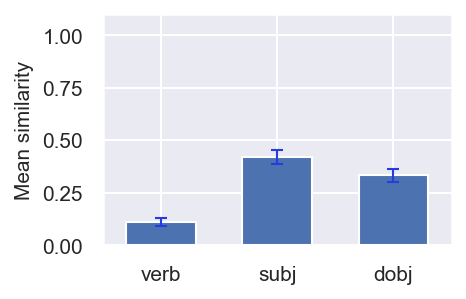

verb: 0.111 ± 0.009
subject: 0.420 ± 0.016
object: 0.333 ± 0.015


In [34]:
## Plots by word type (subj, verb, obj)

# Similarity data to use
sim_data = sim_storage['defsent_cls_norml']

# Organise and align data
ab_verb_no_mods = 1-sim_data[np.intersect1d(ab_verb_indices,modifier_lvl_dict[0])]
ab_subj_no_mods = 1-sim_data[np.intersect1d(ab_subj_indices,modifier_lvl_dict[0])]
ab_dobj_no_mods = 1-sim_data[np.intersect1d(ab_dobj_indices,modifier_lvl_dict[0])]
const_verb_no_mods = sim_data[np.intersect1d(const_verb_indices,modifier_lvl_dict[0])]
const_subj_no_mods = sim_data[np.intersect1d(const_subj_indices,modifier_lvl_dict[0])]
const_dobj_no_mods = sim_data[np.intersect1d(const_dobj_indices,modifier_lvl_dict[0])]
verb_sims = np.append(ab_verb_no_mods,const_verb_no_mods)
subj_sims = np.append(ab_subj_no_mods,const_subj_no_mods)
dobj_sims = np.append(ab_dobj_no_mods,const_dobj_no_mods)

# Compute means and stds
means = [np.mean(x) for x in [verb_sims,subj_sims,dobj_sims]]
std_errs_mean = [scipy.stats.t.ppf(q=0.975, df=len(x))*np.std(x)/np.sqrt(len(x)) for x in [verb_sims,subj_sims,dobj_sims]]

# Prepare bar plot
fig, ax = plt.subplots(figsize=(3,2), dpi=150)
bar_width = 0.6
font_size = 10
x_axis = np.arange(0,len(means))

# Add bars and error bars
ax.bar(x=x_axis, height=means, width=bar_width, tick_label=['verb','subj','dobj'])
ax.errorbar(x=x_axis, y=means, yerr=std_errs_mean, fmt=',', capsize=3, elinewidth=1, color="#273be2")

# Add labels and axes
ax.set_ylabel('Mean similarity', fontsize=font_size)
# ax.set_xlabel('Number of modifiers in sentence', fontsize=font_size)
ax.set_xlim(-0.5,2.5)
ax.set_ylim(0,1.1)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.show()

# Print results
print('verb: {:.3f} ± {:.3f}'.format(np.mean(verb_sims),np.std(verb_sims)/np.sqrt(len(verb_sims))))
print('subject: {:.3f} ± {:.3f}'.format(np.mean(subj_sims),np.std(subj_sims)/np.sqrt(len(subj_sims))))
print('object: {:.3f} ± {:.3f}'.format(np.mean(dobj_sims),np.std(dobj_sims)/np.sqrt(len(dobj_sims))))

### Analysis of training and fine-tuning (STS3k only)

Analysis of fine-tuned models using the STS3k dataset. For SentBERT, finetuning is done using the 'SentenceBERT_finetuning.ipynb' file. For the VerbNet-CN model, fine-tuning consists of training a feedforward neural network on top of the elementwise semantic similarities, which is performed in step 5 of the 'Calc_sent_sim_VerbNet_behav.ipynb' notebook. The fine-tuned embeddings are saved and loaded for analysis in this notebook.

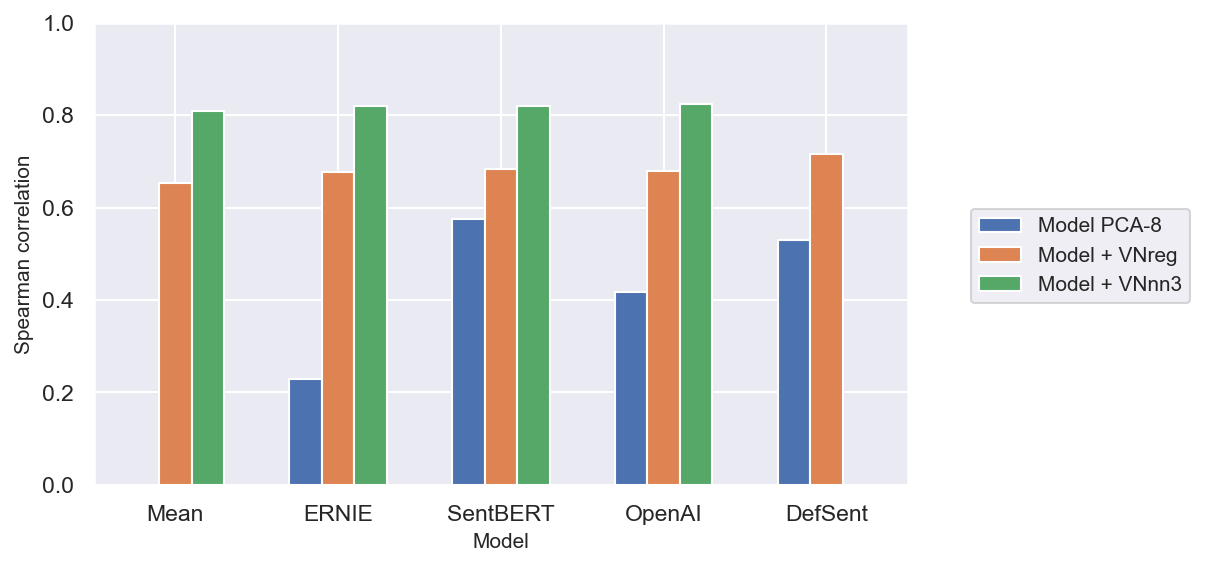

In [50]:
## Plot barplots of transformer models augmented with VerbNet

# Load PCA data for plotting
files_to_plot = os.listdir(file_paths_dict['sims_path']+'\STS3k PCA Comparisons')
pca_sim_scores = {}
for filename in files_to_plot:
    if filename=='readme.txt':
        continue
    file_path = file_paths_dict['sims_path']+'STS3k PCA Comparisons\\'+filename
    with open(file_path, encoding='utf-8') as file:
        pca_sim_scores[filename] = sep.load_sentence_sim_values(file_path)

# Select indices to include
desired_indices = revised_adversarial_no_neg
# desired_indices = all_indices

# Prepare bar plot
fig, ax = plt.subplots(figsize=(7,4), dpi=150)
models_for_plot = ['mean','ernie_12_norml','sentbert_mpnet_norml','openai_norml','defsent_cls_norml']
x_axis_labels = ['Mean','ERNIE','SentBERT','OpenAI','DefSent']
legend_names = ['Model PCA-8', 'Model + VNreg', 'Model + VNnn3']
x_axis = np.arange(len(models_for_plot))
bar_width_mod = 0.2

# Select datasets and add bars for each
i=0
for version in ['base','VNreg','VNnn4']: # select verbnet variation for plotting
    # offset = offsets[i]
    
    # Initialise storage of results
    correlations_with_data = np.zeros(len(models_for_plot))
    
    # Loop over models to be plotted
    for idx,model in enumerate(models_for_plot):
        
        # Select relevant version of each model
        if version=='base': # no VerbNet augmentation
            model_name='STS3k_all_embeddings8-'+model+'_aug-'+model+'_comb-reg_test-train_similarities.txt'
            offset=+2/3
        elif version=='VNreg': # augmentation with VerbNet simple regression
            model_name='STS3k_all_verbnet-8_aug-'+model+'_comb-reg_test-train_similarities.txt'
            offset=0
        elif version=='VNnn4': # augmentation with VerbNet nn4 neural network
            model_name='STS3k_all_verbnet-8_aug-'+model+'_comb-nn3_test-train_similarities.txt'
            offset=-2/3
    
        # Compute and store correlation data
        correlations_with_data[idx] = spearmanr(sim_storage['expr'][desired_indices], pca_sim_scores[model_name][desired_indices])[0]
                   
    # Add bars
    ax.bar(x=x_axis+offset*2*bar_width, height=correlations_with_data, width=bar_width_mod, label=legend_names[i])
    i=i+1

# Add labels and axes
ax.set_ylabel('Spearman correlation', fontsize=font_size)
ax.set_xlabel('Model', fontsize=font_size)
ax.set_xticks(list(x_axis))
ax.set_xticklabels(x_axis_labels)
ax.set_xlim(-0.5,4.5)
ax.set_ylim(0,1)
ax.legend(fontsize=font_size, bbox_to_anchor=(1.36, 0.62), loc='upper right')
plt.show()

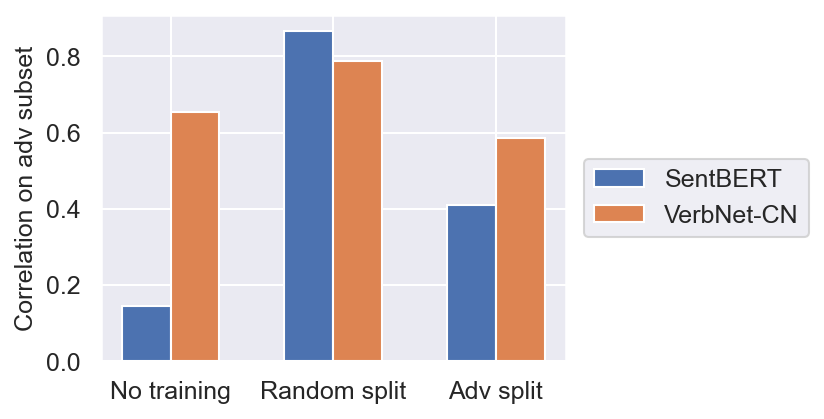

In [68]:
## Effect of fine-tuning on model performance

# Correlations by training type, from the 'Compute correlations with experimental similarities' section above
sentbert_eval_adv = [0.145,0.866,0.410]
verbnet_eval_adv = [0.655,0.787,0.587] # (none_none,mean_nn3,mean_nn3)

# Plot parameters
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
names = ['No training', 'Random split', 'Adv split']
x_axis = np.arange(len(names))/2
font_size = 12
offsets = 1
bar_width = 0.15

# Generate bar plot
plt.bar(x=x_axis-offsets*bar_width/2, height=sentbert_eval_adv, width=bar_width, label='SentBERT')
plt.bar(x=x_axis+offsets*bar_width/2, height=verbnet_eval_adv, width=bar_width, label='VerbNet-CN')
plt.xticks(x_axis, names, fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size, bbox_to_anchor=(1.55, 0.62), loc='upper right')
plt.ylabel('Correlation on adv subset', fontsize=font_size)
plt.show()

STS3k_all_embeddings8-mean_aug-none_comb-reg_test-train_similarities.txt
STS3k_all_embeddings8-mean_aug-none_comb-nn1_test-train_similarities.txt
STS3k_all_embeddings8-mean_aug-none_comb-nn2_test-train_similarities.txt
STS3k_all_embeddings8-mean_aug-none_comb-nn3_test-train_similarities.txt
STS3k_all_embeddings8-sentbert_mpnet_norml_aug-none_comb-reg_test-train_similarities.txt
STS3k_all_embeddings8-sentbert_mpnet_norml_aug-none_comb-nn1_test-train_similarities.txt
STS3k_all_embeddings8-sentbert_mpnet_norml_aug-none_comb-nn2_test-train_similarities.txt
STS3k_all_embeddings8-sentbert_mpnet_norml_aug-none_comb-nn3_test-train_similarities.txt
STS3k_all_embeddings8-openai_norml_aug-none_comb-reg_test-train_similarities.txt
STS3k_all_embeddings8-openai_norml_aug-none_comb-nn1_test-train_similarities.txt
STS3k_all_embeddings8-openai_norml_aug-none_comb-nn2_test-train_similarities.txt
STS3k_all_embeddings8-openai_norml_aug-none_comb-nn3_test-train_similarities.txt
STS3k_all_embeddings8-defsen

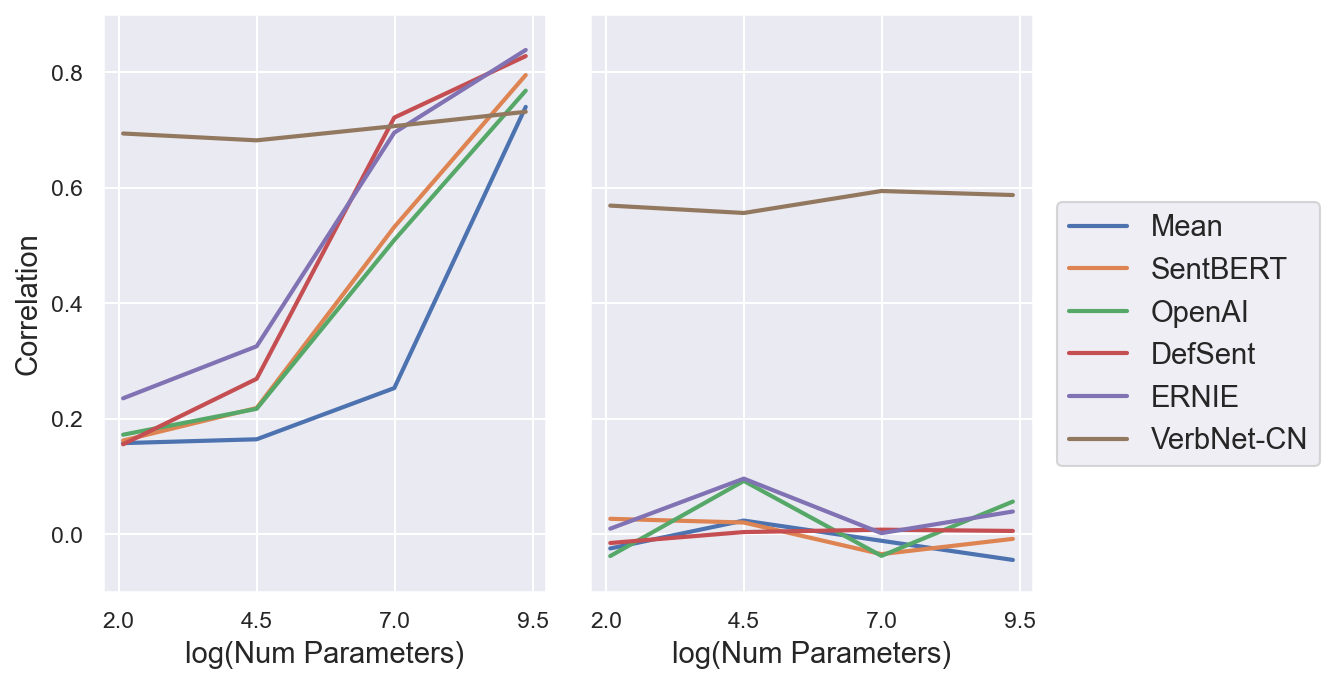

In [60]:
## Plot graphs comparing verbnet and embedding models with fixed parameters using PCA

# Load PCA data for plotting
files_to_plot = os.listdir(file_paths_dict['sims_path']+'\STS3k PCA Comparisons')
pca_sim_scores = {}
for filename in files_to_plot:
    if filename=='readme.txt':
        continue
    file_path = file_paths_dict['sims_path']+'STS3k PCA Comparisons\\'+filename
    with open(file_path, encoding='utf-8') as file:
        pca_sim_scores[filename] = sep.load_sentence_sim_values(file_path)

# Sets of trained model sizes, model types, and labels to use in each of the two subplots
verbnet_sizes = [8,90,1090,11810] # verbnet or embeddings only num params
# verbnet_sizes = [16,170,1570,12610]) # verbnet combined with embeddings
model_types = ['embeddings8-mean_aug-none_comb-', 'embeddings8-sentbert_mpnet_norml_aug-none_comb-', 'embeddings8-openai_norml_aug-none_comb-',
               'embeddings8-defsent_cls_norml_aug-none_comb-', 'embeddings8-ernie_12_norml_aug-none_comb-', 'verbnet-8_aug-none_comb-']
labels = ['Mean', 'SentBERT', 'OpenAI', 'DefSent', 'ERNIE', 'VerbNet-CN']

# Plot parameters
font_size = 14
fig = plt.figure(figsize=(8,5), facecolor='white', dpi=150)
fig.subplots_adjust(wspace=0.1, hspace=0.9)

# Loop over both sets of values to generate both plots
for idx,indices in enumerate([all_indices, revised_adversarial_no_neg]):
    
    # Get correct test/train split
    test_train_split = ['_test-train', '_adversarial'][idx] 
    
    # Combination algorithms and model types to analyse
    comb_alg_types = ['reg','nn1','nn2','nn3']

    # Loop over all models and combination algorithms to compute and store correlations with expr data
    pca_sims_correls = {}
    for model_type in model_types:
        pca_sims_correls[model_type] = [] # create dictionary for correlation values
        for comb_alg in comb_alg_types:
            model_full_name = 'STS3k_all_'+model_type+comb_alg+test_train_split+'_similarities.txt'
            print(model_full_name)
            correlation = spearmanr(sim_storage['expr'][indices], pca_sim_scores[model_full_name][indices])[0]
            pca_sims_correls[model_type].append(correlation) # store values for each model_type

    # Generate line plot
    plot_num = int(str(12)+str(idx+1))
    fig_axis = fig.add_subplot(plot_num)
    i=0
    for model_type in pca_sims_correls.keys():
        fig_axis.plot(np.log(verbnet_sizes), pca_sims_correls[model_type], label=labels[i], linewidth=2)
        if idx>0:
            fig_axis.legend(fontsize=font_size, bbox_to_anchor=(1.68, 0.7), loc='upper right')
            fig_axis.set_yticklabels([])
        if idx==0:
            fig_axis.set_ylabel('Correlation', fontsize=font_size)
        fig_axis.set_xlabel('log(Num Parameters)', fontsize=font_size)
        fig_axis.set_ylim(-0.1,0.9)
        fig_axis.set_xticks([2,4.5,7,9.5])
        i+=1

plt.show()